# Gray Level Co-occurrence Matrices (GLCM)

In this notebook, we will demonstrate how to use Gray Level Co-occurrence Matrices (GLCM), also known as _haralick features_, to perform texture analysis with PyImageJ. To learn more on GLCM and its applications, please visit the [GLCM wikipedia](https://en.wikipedia.org/wiki/Co-occurrence_matrix) page. 

In this example, we will work with a 2D image (shape: `(500, 500)`) of HeLa cells infected with HIV<sub>NL4-3</sub> expressing [mVenus](https://www.fpbase.org/protein/mvenus/) tagged Gag polyprotein. The field of view contains 4 cells, 3 of which are at _below_ the cooperative threshold for Gag assembly (_i.e._ the concentration of HIV Gag is too low to multimerize into viral particles at the plasma membrane) and 1 cell at or _above_ the assembly threshold<sup>1</sup>. This workflow extracts 6 crops from the sample image, 4 crops from each of the cells and 2 crops from the background, and computes the GLCM _correlation_ and _difference variance_ values. By analyzing the texture of the crops from each cell's cytoplasm we can identify cells in active viral particle production (cell 4) and cells that are expressing the flourescent Gag protein but not yet producing viral particles (cells 1, 2 and 3).

![Cells with labels](https://media.imagej.net/pyimagej/doc/images/glcm_cell_label.png)

<sup>_Cells 1, 2 and 3 are below Gag assembly threshold and are **not** making viral particles. Cell 4 is at or above the assembly threshold and **is** making viral particles._</sup>

## Texture analysis with GLCM

The GLCM operation requires 3 parameters, in addition to the input image, that need to be carefully selected.

- [Gray levels](#gray-levels)
- [Distance](#distance)
- [Orientation/Angle](#orientationangle)

### Gray Levels

The number of discrete intensity values to bin the image pixel data into. Typically you want to select a value that is smaller than the maximum gray value of the given image as a power of 2. For example, if your image is 8-bit then the maximum gray value (_i.e._ the maximum value you can store in an 8-bit address) is 255. Therefore, good _gray level_ values for 8-bit images are powers of 2 smaller than 255:

| 2<sup>_n_</sup> | Value |
| :---:           | :---: |
| 2<sup>1</sup>   | 2     |
| 2<sup>2</sup>   | 4     |
| 2<sup>3</sup>   | 8     |
| 2<sup>4</sup>   | 16    |
| 2<sup>5</sup>   | 32    |
| 2<sup>6</sup>   | 64    |
| 2<sup>7</sup>   | 128   |

### Distance

The distance a pair of pixels at a given orientation/angle to consider. This value should be adjusted for your dataset. For fine textures start with small pixel distance values (_e.g._ 2). For coarser details use a larger distance value.

### Orientation/Angle

The angle at which pairs of pixels are compared, using the specified pixel distance, to check for co-occurrence. A specific angle can be used for rotationally significant features, or for rotationally invariant features, co-occurrence matrices can be iteratively generated at varying angles and averaged together.

### Available GLCM texture analyses in imagej-ops

The `imagej-ops` framework offers the following GLCM/Haralick feature texture measurements:

- Angular Secondary Moment (ASM)
- Cluster Prominence
- Cluster Shade
- Contrast
- Correlation
- Difference Entropy
- Difference Variance
- Entropy
- Information Measure of Correlation 1 (icm1)
- Information Measure of Correlation 2 (icm2)
- Inverse Difference Moment (ifdm)
- Max Probability
- Sum Average
- Sum Entropy
- Texture Homogeneity
- Variance

### Correlation and Difference Variance GLCM textures

This notebook will use two texture measurements: _correlation_ and _difference variance_. The _correlation_ texture measurement is a measure of linear gray level dependency between a given set of pixels. High _correlation_ values indicate there is a strong linear relationship between the gray levels in the image. Conversely, low _correlation_ values indicate a weak linear relationship. Visually a texture with a higher _correlation_ value indicates a smoother or more uniform texture, while a lower value suggests an image texture with more rapid changes and variations in pixel intensity.

The _difference variance_ texture is a measure of pixel intensity variation between a given set of pixels. High _difference variance_ values indicate that there is significant pixel intensity variation between a given set of pixel gray levels. Low _difference variance_ values indicate that there are fewer transitions between gray level pair values. Visually, a texture with a higher _difference variance_ value may appear noisy, whereas a texture with a lower _difference variance_ value will appear more homogeneous.

With these two textures measurements we can analyze an image and determine how **smooth** and **variable** the images are.

## Using PyImageJ and imagej-ops for GLCM texture analysis

Let's start by first initializing ImageJ2 and import the needed Java classes.

In [1]:
import imagej
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches

ij = imagej.init(add_legacy=False)
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.14.0


Next we need to import the `MatrixOrientation2D` Java class which contains angle parameters we can specify. To make it easy to use all four angles (_antidiagonal_, _diagonal_, _horizontal_ and _vertical_), let's load the `MatrixOrientation2D` orientations into a list.

In [2]:
# get MatrixOrientation2D Java class
MatrixOrientation2D = imagej.sj.jimport('net.imagej.ops.image.cooccurrenceMatrix.MatrixOrientation2D')

# create orientation list
orientations = [
    MatrixOrientation2D.ANTIDIAGONAL,
    MatrixOrientation2D.DIAGONAL,
    MatrixOrientation2D.HORIZONTAL,
    MatrixOrientation2D.VERTICAL
]

The following cell will set up the `run_glcm()` and `process_crops()`functions. The `run_glcm()` function accepts a single 2D image, obtains the _correlation_ and _difference variance_ GLCM texture values and returns a tuple. The `process_crops()` function will process a `dict` of crops we will generate later and feeds each crop to the `run_glcm()` function. Because this dataset does not have any rotationally significant features, the `process_crops()` function will iterate through all 4 orientations and average the results before returning a `pandas.DataFrame`. Once we have the `pandas.DataFrame` we can easily plot the data on a scattter plot.

In [3]:
def run_glcm(img, gray_levels: int, dist: int, angle):
    """
    Compute the correlation and difference variance GLCM textures from an image.

    :param img: An input ImgPlus
    :param gray_levels: Number of gray levels
    :param dist: Distance in pixels
    :param angle: MatrixOrientation2D angle
    :return: A tuple of floats: (correlation, difference variance)
    """
    # compute correlation and difference variance
    corr = ij.op().haralick().correlation(img, gray_levels, dist, angle)
    diff = ij.op().haralick().differenceVariance(img, gray_levels, dist, angle)
    
    # convert to Python float
    corr = ij.py.from_java(corr)
    diff = ij.py.from_java(diff)

    return (corr.value, diff.value)

def process_crops(crops, gray_levels: int, dist: int) -> pd.DataFrame:
    """
    Process a dict of ImgPlus images with GLCM texture analysis.

    :param crops: A dict of ImgPlus images
    :param gray_levels: Number of gray levels
    :param dist: Distance in pixels
    :return: Pandas DataFrame
    """
    glcm_mean_results = []
    for key, value in crops.items():
        glcm_angle_results = []
        image = ij.py.to_dataset(value) # convert the view to a net.imagej.Dataset
        # compute the correlation and difference variance textures at all orientations
        for angle in orientations:
            glcm_angle_results.append(run_glcm(image, gray_levels, dist, angle))
        # calculate the mean of the angle results
        corr_mean = sum(x[0] for x in glcm_angle_results) / len(glcm_angle_results)
        diff_mean = sum(x[1] for x in glcm_angle_results) / len(glcm_angle_results)
        glcm_mean_results.append((corr_mean, diff_mean))

    return pd.DataFrame(glcm_mean_results, columns=['corr', 'diff'])

We also need to specify the number of `gray_levels` and the `dist` before we can perform the texture analysis. Here we selected 128 for `gray_levels` and a `dist` of 7 pixels.

In [4]:
# set up GLCM parameters
gray_levels = 128 # a value lower than the bit depth of the image and typically a power of 2
dist = 7 # distance in pixels

Now let's load the sample data and view the image.

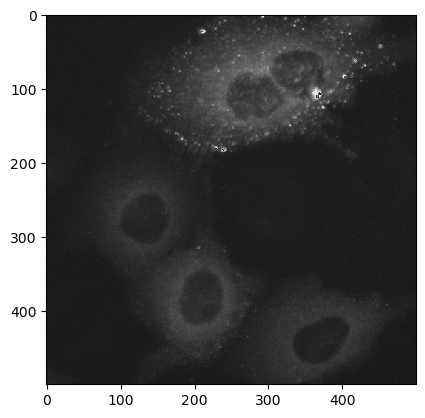

In [5]:
# load sample data from media.imagej.net
data = ij.io().open('https://media.imagej.net/workshops/data/2d/hela_hiv_gag-yfp.tif')

# convert the net.imagej.Dataset to xarray.DataArray
data_xarr = ij.py.from_java(data)
ij.py.show(data_xarr * 12, cmap='Greys_r') # multiply by 12 to better visualize the data (doesn't change source)

Next we want a total of 6 crops of shape `(50, 50)` from the input image: 1 crop from each of the four cells, and 2 crops from the background. The exact location of each crop isn't critical, but a crop should only contain pixels from its particular target. The following cell does 3 things: (1) create a `dict` of crops by slicing* the original data, (2) create a `dict` of the min X and min Y coordinates, (3) display the crops in a 2 x 3 matplotlib grid.

*: _Slicing a `net.imagej.DefaultDataset` like we do here to produce crops, returns a view._

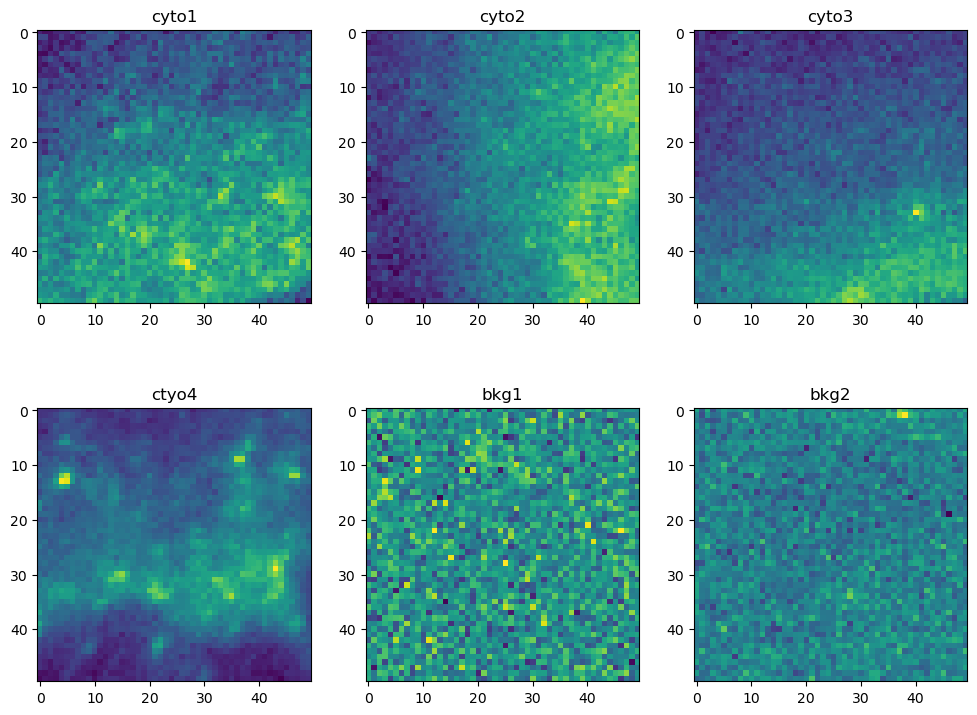

In [6]:
# create 50 x 50 crops from the input image (note that these slices are Java objects)
crops = {
    "cyto1": data[318: 368, 369: 419], # cell 1 cytoplasm crop
    "cyto2": data[130: 180, 355: 405], # cell 2 cytoplasm crop
    "cyto3": data[87: 137, 194: 244],  # cell 3 cytoplasm crop
    "cyto4": data[256: 306, 43: 93],   # cell 4 cytoplasm crop
    "bkg1": data[19: 69, 57: 107],     # background 1 crop
    "bkg2": data[263: 313, 221: 271]   # background 2 crop
}

# store the min x and min y values to draw crop boxes
crop_coords = {
    "cyto1": (318, 369),
    "cyto2": (130, 355),
    "cyto3": (87, 194),
    "cyto4": (256, 43),
    "bkg1": (19, 57),
    "bkg2": (263, 221)
}

# view the crops in a 2 x 3 grid in matplotlib
fig, ax = plt.subplots(2, 3, figsize=(12, 9))
ax[0, 0].imshow(ij.py.from_java(crops.get("cyto1")))
ax[0, 0].set_title("cyto1")
ax[0, 1].imshow(ij.py.from_java(crops.get("cyto2")))
ax[0, 1].set_title("cyto2")
ax[0, 2].imshow(ij.py.from_java(crops.get("cyto3")))
ax[0, 2].set_title("cyto3")
ax[1, 0].imshow(ij.py.from_java(crops.get("cyto4")))
ax[1, 0].set_title("ctyo4")
ax[1, 1].imshow(ij.py.from_java(crops.get("bkg1")))
ax[1, 1].set_title("bkg1")
ax[1, 2].imshow(ij.py.from_java(crops.get("bkg2")))
ax[1, 2].set_title("bkg2")

# display the 2 x 3 image grid
plt.show()

Viewing the crops in a 2 x 3 grid is helpful, but its hard to determine where these particular crops are extracted from in the original image. The next cell will display the original input image with red boxes indicating the location each crop was extracted from.

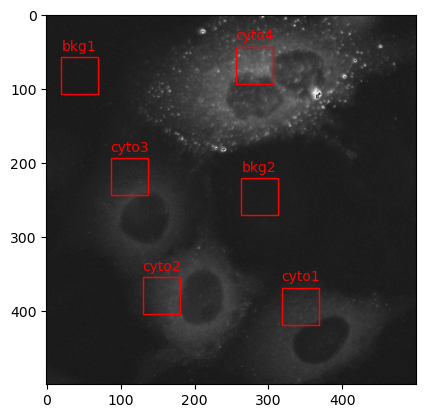

In [7]:
# display the original image (multiplied by 12 to increase it's brightness)
plt.imshow(data_xarr * 12, cmap='Greys_r')

# create red boxes for each crop on top of the original image
for key, value in crop_coords.items():
    x = value[0]
    y = value[1]
    rect = patches.Rectangle((x, y), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    # add a label above each box
    plt.text(x + 25, y - 15, key, color='r', ha='center', va='center')

# display the original image with red crop boxes
plt.show()

Finally, we can now perform the _correlation_ and _difference variance_ GLCM texture analysis. This last cell uses the `process_crops()` function that we setup earlier, which processes each crop in the `crops` dictionary with the `run_glcm()` function. The output `pandas.DataFrame` is then plotted on a matplotlib scatter plot.


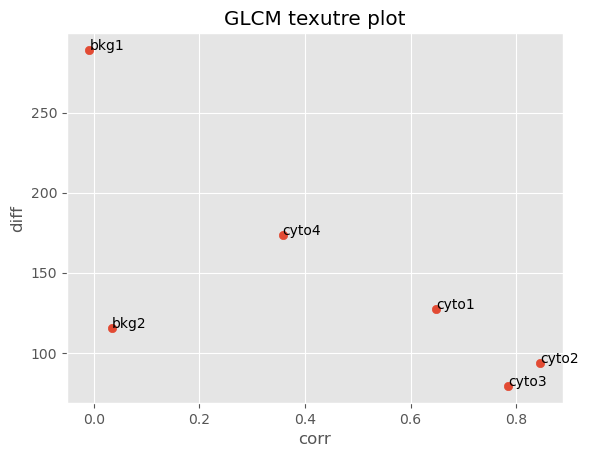

In [8]:
# set plot style
plt.style.use('ggplot')

# process the dict of crops and add crop names to the output dataframe
df = process_crops(crops, gray_levels, dist)
df["name"] = ["cyto1", "cyto2", "cyto3", "cyto4", "bkg1", "bkg2"]

# plot the data in a matplotlib scatter plot
plt.scatter(df['corr'], df['diff'])

# add labels
for i in range(len(df)):
    plt.annotate(f"{df['name'][i]}", (df['corr'][i], df['diff'][i]))

# add labels and title
plt.xlabel('corr')
plt.ylabel('diff')
plt.title('GLCM texutre plot')

# display the scatter plot
plt.show()

In the resulting scatter plot we can clearly see that our crops clustered in descrete regions. Crops `cyto1`, `cyto2` and `cyto3` which all come from the cytoplasm of cells expressing mVenus-Gag _below_ the Gag multimerization threshold (_i.e._ these cells are **not** making viral particles) clustered in a region with high _correlation_ and low _difference variance_ values, indicating that these images are smooth and invariant. Crops `bkg1` and `bkg2` are extracted from the background. Interestingly, while they appear visually smooth they have a low GLCM _correlation_ value indicating they are infact **not homogenous**. The _difference variance_ values for `bkg1` and `bkg2` suggests `bkg1` is more variable in signal inensity than `bkg2`. Looking back at the 2 x 3 grid of crops we made earlier, we can see that indeed `bkg1` and `bkg2` are not homogenous and `bkg1` appears more noisy than `bkg2`. Lastly crop `cyto4`, which was extracted from the cell at or above the Gag multimerization threshold (_i.e._ the cell is producing viral particles) has a lower _correlation_ value than `cyto1`, `cyto2` and `cyto3` but a higher value than `bkg1` and `bkg2`. This suggests that `cyto4` is not as smooth as the other cells but smoother than the background. 

By measuring the GLCM _correlation_ and _difference variance_ textures we can distinguish cells that are in the assembly stage of the viral life cycle and are producing viral particles and those that are not.

## References

<sup>1</sup>: [Becker _et. al_, _J Virol_ 2017](https://pubmed.ncbi.nlm.nih.gov/28053097/)